# Setup

In [ ]:
from pathlib import Path
import platform
import os
import shutil
import time
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pylab as plt
import spikeinterface.full as si    # may need to run pip install in the spikeinterface folder first
import probeinterface as pi
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# import ipywidgets
%matplotlib widget

# Import my custom modules
from src import spikeinterface_hp 
# from src import rhdutilities 
from src import load_probe_rhd 
import importlib  # Allow module reloads in case any changes were made after starting the kernel: importlib.reload(spikeinterface_hp)

# Add path to kilosort2 and ironclust repos
si.Kilosort2Sorter.set_kilosort2_path(Path.resolve(Path('../../Kilosort-2.0')))
si.IronClustSorter.set_ironclust_path(Path.resolve(Path('../../ironclust')))

# Print SI version
print(f"SpikeInterface version: {si.__version__}")

# Print list of installed sorters
# print(si.installed_sorters())

Option 1: Make toy example recording data in the results folder

In [ ]:
%%script False

# Set paths that are used throughout: results and data
results_path = Path.resolve(Path('..','results')) 
print(results_path)
data_path = results_path/'toy_example_recording'
print(data_path)

# Make the toy example in the data folder
if not data_path.exists():
    recording_raw, sorting = si.toy_example(num_segments=1, duration=100, seed=1, num_channels=16, num_columns=2)
    recording_raw.save(folder=data_path)
    print('Created toy data')
else:
    print('Toy data already exists')

recording_raw = si.load_extractor(data_path)
recording_cmr = recording_raw # It is already filtered and common median filtered

Option 2: Load REAL data from the server

In [ ]:
# Set paths that are used throughout: results and data
results_path = Path('Z:/Hannah/ephys/project2/HC05_220819')   #  A 32 channel recording, shank A only
# results_path = Path('Z:/Hannah/ephys/project2/test64b')    # A short 64 channel recording (all noise, no real spikes)
data_path = [f for f in results_path.iterdir() if f.is_dir() and f.name.startswith('raw')] # subfolder starting with raw*. Should only be one!
data_path = data_path[0] # Set data_path to the folder containing the intan.rhd file etc
print(data_path)

importlib.reload(spikeinterface_hp)
recording_raw = spikeinterface_hp.read_intan_dat(data_path)

# Load the probe for this file
importlib.reload(load_probe_rhd)
probe = load_probe_rhd.H6(data_path/'info.rhd', results_path/'probe.json')
recording_raw = recording_raw.set_probe(probe, group_mode="by_shank")

# Visualizations/checks
probe = recording_raw.get_probe() # sorts by index in .dat file
print(probe.to_dataframe(complete=True).loc[:, ['x','y','contact_ids', 'shank_ids', 'device_channel_indices']])
pi.plotting.plot_probe(probe, with_channel_index=True) 
# pi.plotting.plot_probe(probe, with_device_index=True) # Now the channel index matches the device index bc it was sorted


Using a built in probe:

In [ ]:
%%script false # Don't run this cell!

# Built-in probe
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-236-H6'
probe = pi.get_probe(manufacturer, probe_name)  

# map channels to device indices
mapping_to_device = [
53,55,61,63,62,60,58,56,54,52,50,46,48,47,43,45,57,59,42,40,38,36,34,44,32,30,28,26,24,22,23,27,51,49,0,2,4,6,8,7,10,12,14,16,18,20,21,19,41,39,37,35,33,31,29,25,17,9,11,15,13,5,3,1
]
probe.set_device_channel_indices(mapping_to_device)
# probe.wiring_to_device('ASSY-236>RHD2164') # Built-in

fig, ax = plt.subplots()
pi.plotting.plot_probe(probe, with_device_index=True, ax=ax) # with_contact_id=True
pprint(probe.to_dataframe(complete=True).loc[:, ['x','y','contact_ids', 'shank_ids', 'device_channel_indices']])

# Load the probeinterface object to the SI recording object:
recording_raw = recording_raw.set_probe(probe, group_mode="by_shank")

# When loading the probe, it is automatically sorted by device indices (the order the data is stored on disk):
probe_rec = recording_raw.get_probe()
print(probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]])
print("Properties after loading the probe:", list(recording_raw.get_property_keys()))


Bandpass filter and apply common median reference

In [ ]:
# Extract 10 minute segment for testing purposes
# fs = recording_raw.get_sampling_frequency()
# recording_raw = recording_raw.frame_slice(start_frame=0*fs, end_frame=300*fs)

# Filter
recording_f = si.highpass_filter(recording_raw, freq_min=300) # Not recommended to throw out high frequencies before sortin
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

# Plot the traces after applying CMR:
# w = si.plot_timeseries({"filt": recording_f, "common": recording_cmr}, 
#   clim=(-1000, 1000), order_channel_by_depth=False,show_channel_ids=True, backend="ipywidgets") #ipywidgets only works in browser - run jupyter notebook in anaconda prompt
w = si.plot_timeseries({"filt": recording_f, "common": recording_cmr},
    order_channel_by_depth=False, time_range=[10,11], channel_ids=range(16), show_channel_ids=True)
# Note: if order_by_channel_depth=True, the order is messed up between the two inputs!

# Cache the filtered recording to speed some things up later? and allow phy to load it?
# recording_cmr_folder = Path('C:/Temp/spikeinterface')
# while os.path.isdir(recording_cmr_folder): shutil.rmtree(recording_cmr_folder, ignore_errors=True)
# recording_saved = recording_cmr.save(folder=recording_cmr_folder, n_jobs=-1, total_memory="2G") # , n_jobs=-1, total_memory="10G"
# print(recording_cmr.get_binary_description()['file_paths'])

# If it's already saved
# recording_cmr = si.load_extractor(recording_cmr_folder)

General sorting/waveform/phy settings

In [ ]:
# waveform extractor settings
ms_before = 1.5 # default 3
ms_after = 2.5  # default 4
max_spikes_per_unit = 500

# export_to_phy setting
max_ch_per_template = 8
chunk_duration = '10s'
n_jobs = -1

# Run spikesorting

Note: make sure your startup.m file in Matlab doesn't change the current directory!

Change Kilosort2 params

In [ ]:
default_kilosort2_params = si.Kilosort2Sorter.default_params()
pprint(default_kilosort2_params)
# default_kilosort2_params['reorder'] = 0 # Can't access this?
#TODO: increase batch size to avoid losing sparsely active cells?
default_kilosort2_params['freq_min'] = 300            # SC setting: 150->300. Keep it on even if pre-filtering https://github.com/MouseLand/Kilosort/issues/276

# default_kilosort2_params['minFR'] = 0.02              # Default in Matlab is 0.02, default in SI is 0.1
# default_kilosort2_params['minfr_goodchannels'] = 0.02 # Default in Matlab is 0.02, default in SI is 0.1
# default_kilosort2_params['NT'] = 64*1024+default_kilosort2_params['ntbuff'] # SC increased to 4*64*1024+ope.ntbuff (128)

# default_kilosort2_params['car'] = False               # Already did this
# default_kilosort2_params['nfilt_factor'] = 8 # SC increased from 4 to 8 # max number of clusters per good channel (even temporary ones)

# default_kilosort2_params['detectArtifacts'] = False
# ops.nfilt_factor        = 8;    % (SC changed from 4) % max number of clusters per good channel (even temporary ones)
# ops.ntbuff              = 128;  % (SC changed from 64) % samples of symmetrical buffer for whitening and spike detection


Run kilosort2

In [ ]:
# Run sorter
sorter_name = 'kilosort2'
sorting_folder = results_path/(sorter_name+'_output')
sorting = si.run_sorter(sorter_name, recording_cmr, sorting_folder, verbose=True, remove_existing_folder=True) # **default_kilosort2_params. Use recording_cmr instead??
print(sorting_folder)
print(sorting)
os.remove(sorting_folder/'temp_wh.dat') # Remove large temporary file

# Save sorting in spike interface .npz format
sorting_save_path = results_path/(sorter_name+'_si_output')
sorting.save(folder=sorting_save_path)
print(sorting_save_path)

# TODO: Delete original sorting folder after it is exported, either to Phy, or skip the waveforms/phy export, and save sorting as npz format?


In [49]:
# %%script false

# To export the original sortings to phy:
sorter_name = 'kilosort2'
output_folder = results_path/(sorter_name+'_si_output')

# Extract waveforms
waveform_folder = results_path/(sorter_name+'_waveforms')
print(waveform_folder)
sorting = si.load_extractor(output_folder) # Load the sorting results (only needed if picking up from here)
we = si.extract_waveforms(recording_raw, sorting, waveform_folder, return_scaled=True, overwrite=True, # TODO check effect of raw or cmr??
    n_jobs=n_jobs, chunk_duration=chunk_duration, max_spikes_per_unit=max_spikes_per_unit,ms_before=ms_before, ms_after=ms_after) #total_memory="10M",  
    #NOTE: return_scaled: If True and recording has gain_to_uV/offset_to_uV properties, waveforms are converted to uV.

# Export to phy
we = si.WaveformExtractor.load_from_folder(waveform_folder) # Load the waveforms results (only needed if picking up from here)
we.recording = recording_raw # Just do this so that the path to the raw .dat file is stored in params.py
phy_folder =  results_path/(sorter_name+'_phy')
print(phy_folder)
si.export_to_phy(we, output_folder=phy_folder,remove_if_exists=True,copy_binary=False,compute_amplitudes=True,
    max_channels_per_template=max_ch_per_template, chunk_duration=chunk_duration, n_jobs=n_jobs) 

Z:\Hannah\ephys\project2\HC05_220819\kilosort2_waveforms
Z:\Hannah\ephys\project2\HC05_220819\kilosort2_phy
Run:
phy template-gui  Z:\Hannah\ephys\project2\HC05_220819\kilosort2_phy\params.py


Run Ironclust

In [ ]:
# Run sorter
sorter_name = 'ironclust'
sorting_folder = results_path/(sorter_name+'_output')
sorting = si.run_sorter(sorter_name, recording_raw, sorting_folder, verbose=True, remove_existing_folder=True) # filter=False, detect_threshold=1
print(sorting)

# Save sorting in spike interface .npz format
sorting_folder = results_path/(sorter_name+'_si_output')
sorting.save(folder=sorting_folder)
print(sorting_folder)

In [ ]:
%%script false

# Get waveforms
waveform_folder = results_path/(sorter_name+'_waveforms')
we = si.extract_waveforms(recording_cmr, sorting, waveform_folder,return_scaled=True, overwrite=True,
    n_jobs=n_jobs, chunk_duration=chunk_duration, max_spikes_per_unit=max_spikes_per_unit,ms_before=ms_before, ms_after=ms_after)

# Export to Phy
phy_folder = results_path/(sorter_name+'_phy')
si.export_to_phy(we, sorting_folder=phy_folder,remove_if_exists=True,copy_binary=False,compute_amplitudes=True,
    max_channels_per_template=max_ch_per_template, chunk_duration=chunk_duration, n_jobs=n_jobs) 

# Post-processing

Get Quality metrics for KS sorting

In [ ]:
# Get quality metrics for all KS sorting
waveform_folder = results_path/'kilosort2_waveforms'
we = si.WaveformExtractor.load_from_folder(waveform_folder) # Load the waveforms results (only needed if picking up from here)
metric_names=['snr', 'isi_violation', 'amplitude_cutoff','isolation_distance','firing_rate']
# NOTE: isi_violations_rate: "Rate of contaminating spikes as a fraction of overall rate. Higher values indicate more contamination" (== #sp_bad/#sp_total)
# Q: how to set bin width and refractory period for ISI violations?

qm = si.compute_quality_metrics(we,load_if_exists=True,metric_names=metric_names)
qm = qm.drop('isi_violations_ratio')
score_filename = results_path/'si_qm.csv'
qm.to_csv(score_filename)


d:\hannah\dropbox\code\spikesort\spikeinterface\spikeinterface\qualitymetrics\misc_metrics.py:404: UserWarning: Amplitude PDF does not have a unique minimum! More spikes might be required for a correct amplitude_cutoff computation!
  warnings.warn("Amplitude PDF does not have a unique minimum! More spikes might be required for a correct "


Load the two sortings

In [ ]:
# Load sortings from .npz format (SI preferred):
sorting_ks = si.load_extractor(results_path/('kilosort2_si_output')) # Load the sorting results (only needed if picking up from here)
sorting_ic = si.load_extractor(results_path/('ironclust_si_output')) # Load the sorting results (only needed if picking up from here)

# Load sortings - from kilosort2/ironclust output folder
# sorting_ks = si.read_kilosort(results_path/'kilosort2_output')
# sorting_ic = si.read_mda_sorting(results_path/'ironclust_output'/'tmp'/'firings.mda',sampling_frequency=recording_raw.get_sampling_frequency()) #_get_result_from_folder? read_mda_sorting

# Load sortings - from phy folder
# sorting_ks = si.read_phy(results_path/'kilosort2_phy') # Alternate if saved as phy
# sorting_ic = si.read_phy(results_path/'ironclust_phy') # Alternate if saved as phy

sub = '' #add onto output folders


Option 1: Compare with one as reference

<class 'pandas.core.series.Series'>
0     -1.0
1     -1.0
2      9.0
3      8.0
4     -1.0
5     10.0
6     -1.0
7     14.0
8     13.0
9     -1.0
10    -1.0
11    17.0
12    20.0
13    -1.0
14    -1.0
15    -1.0
16    21.0
17    -1.0
18    -1.0
19    -1.0
20    27.0
21    -1.0
22    25.0
23     5.0
24    -1.0
25    -1.0
26    -1.0
27    -1.0
28    -1.0
29    -1.0
30    -1.0
31    -1.0
32    -1.0
33    33.0
34    -1.0
35    -1.0
36    -1.0
37    -1.0
38    11.0
39    18.0
40    -1.0
dtype: float64


In [97]:

# agreement_df.to_csv(score_filename)
match_to_ks = match_to_ks.rename('match')
match_to_ks.to_csv(match_filename) # header=False


In [80]:
# Compare two sorters
comp_ks_ic = si.compare_two_sorters(sorting1=sorting_ks, sorting2=sorting_ic)  # returns SortingComparison object
print('Relative to Kilosort2:')
match_to_ks = comp_ks_ic.hungarian_match_12
match_to_ic = comp_ks_ic.hungarian_match_21

# Save all the best agreement scores for each KS cell (not necessarily the matched scores)
# score_df = pd.DataFrame({'ks_ind': range(len(match_to_ks)), 'ic_ind':match_to_ks,'score': comp_ks_ic.agreement_scores.max(axis=1) })
score_filename = results_path/'si_score_all.csv'
comp_ks_ic.agreement_scores.to_csv(score_filename)

# Return the agreement scores just for the matching units
# agreement_scores = comp_ks_ic.agreement_scores
# ks_ind = np.nonzero([match_to_ks!=-1])[1]
# ic_ind = match_to_ks.to_numpy()
# ic_ind = ic_ind[match_to_ks!=-1].astype(int)
# agreement_scores=agreement_scores.to_numpy()
# agreement_scores_match = agreement_scores[(ks_ind,ic_ind)]
# agreement_df = pd.DataFrame({'ks_ind': ks_ind, 'ic_ind': ic_ind, 'score':  agreement_scores_match} )
# pprint(agreement_df)

# score_filename = results_path/'si_score_match.csv'
# agreement_df.to_csv(score_filename)
match_to_ks = match_to_ks.rename('match')
match_filename = results_path/'si_match.csv'
match_to_ks.to_csv(match_filename) # header=False

# Select only the matched units from the kilosort sorting
ks_ind = np.nonzero([match_to_ks!=-1])[1]
print(ks_ind)
sorting_clean = sorting_ks.select_units(ks_ind)
print(sorting_clean)

# Get waveforms
waveform_folder = results_path/('clean_waveforms'+sub)
we = si.extract_waveforms(recording_cmr, sorting_clean, waveform_folder,return_scaled=True, overwrite=True,
    n_jobs=n_jobs, chunk_duration=chunk_duration, max_spikes_per_unit=max_spikes_per_unit,ms_before=ms_before, ms_after=ms_after)

# Export to Phy
phy_folder = results_path/('clean_phy'+sub)
we.recording = recording_raw # Just do this so that the path to the raw .dat file is stored in params.py
si.export_to_phy(we, output_folder=phy_folder,remove_if_exists=True,copy_binary=False,compute_amplitudes=True,
    max_channels_per_template=max_ch_per_template, chunk_duration=chunk_duration, n_jobs=n_jobs)

Relative to Kilosort2:
    ks_ind  ic_ind     score
0        2       9  0.989676
1        3       8  0.816065
2        5      10  0.703223
3        7      14  0.851179
4        8      13  0.924846
5       11      17  0.735485
6       12      20  0.651452
7       16      21  0.962452
8       20      27  0.863674
9       22      25  0.964706
10      23       5  0.773793
11      33      33  0.638806
12      38      11  0.989510
13      39      18  0.525217
[ 2  3  5  7  8 11 12 16 20 22 23 33 38 39]
UnitsSelectionSorting: 14 units - 1 segments - 30.0kHz


Option 2: Find consensus

In [ ]:
%%script false 
comp_intersection = si.compare_multiple_sorters(sorting_list=[sorting_ks, sorting_ic],
    name_list=['ks', 'ic'], spiketrain_mode='intersection',n_jobs=-1)

output_folder_intersect = results_path/('intersect_output'+sub)
sorting_agreement = comp_intersection.get_agreement_sorting(minimum_agreement_count=2)
sorting_agreement = sorting_agreement.save(folder=output_folder_intersect)

# Get waveforms
waveform_folder = results_path/('intersect_waveforms'+sub)
si.extract_waveforms(recording_cmr, sorting_agreement, waveform_folder,ms_before=ms_before, ms_after=ms_after,
    n_jobs=n_jobs, chunk_duration=chunk_duration, max_spikes_per_unit=max_spikes_per_unit, return_scaled=True, overwrite=True)
we = si.WaveformExtractor.load_from_folder(waveform_folder)

# Export to Phy
phy_folder = results_path/('intersect_phy'+sub)
we.recording = recording_raw # Just do this so that the path to the raw .dat file is stored in params.py
si.export_to_phy(we, output_folder=phy_folder,remove_if_exists=False,copy_binary=False,compute_amplitudes=True,
    max_channels_per_template=max_ch_per_template, chunk_duration=chunk_duration, n_jobs=n_jobs)


Units in agreement, intersect: [ 2  3  5  7  8 11 12 16 20 22 23 33 38 39]


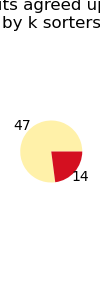

In [47]:
%%script false --no-raise-error

# Load union and intersects
output_folder_intersect = results_path/'intersect_output'
sorting_agreement = si.load_extractor(output_folder_intersect)
print('Units in agreement, intersect:', sorting_agreement.get_unit_ids())

# Plot matching results
# np.close('all')
fig,ax = plt.subplots(1,1,figsize=[1,3])
ax.axis('equal')
w = si.plot_multicomp_agreement(comp_intersection,ax=ax)


Example: Quality metrics & automatic curation for single sorter

In [ ]:
%%script false
waveform_folder = results_path/'kilosort2_waveforms'

# Load waveforms
we = si.WaveformExtractor.load_from_folder(waveform_folder) # Only needed if picking up from here

# Specifiy quality metrics
print(si.get_quality_metric_list())
metric_names=['snr', 'isi_violation', 'amplitude_cutoff','isolation_distance','firing_rate']
# NOTE: isi_violations_rate: "Rate of contaminating spikes as a fraction of overall rate. Higher values indicate more contamination" (== #sp_bad/#sp_total)
# Q: how to set bin width and refractory period for ISI violations?

# Compute quality metrics
qm = si.compute_quality_metrics(we,load_if_exists=True,metric_names=metric_names)
pprint(qm)

# Plot quality metrics
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "isi_violations_rate","firing_rate"])

# Screen sorting based on quality metrics
firing_rate_cutoff = 50
isi_viol_thresh =  0.1 # 0.2 is KS2 default
amplitude_cutoff_thresh = 0.05
our_query = f"firing_rate < {firing_rate_cutoff} & isi_violations_rate < {isi_viol_thresh} & amplitude_cutoff < {amplitude_cutoff_thresh} "

qm_keep = qm.query(our_query)
keep_unit_ids = qm_keep.index.values
sorting_clean = we.sorting.select_units(keep_unit_ids)
print(sorting)
print(sorting_clean)

Launch phy

In [ ]:
%%script false # don't run this cell!

# Launch Phy
phy_folder = results_path/'clean_phy'
from phy.apps.template import template_gui
template_gui(phy_folder/'params.py')

Parking lot

In [ ]:
%%script false # don't run this cell!

# Check data type of .npy file
from pprint import pprint
from pathlib import Path
import numpy as np
# file = Path(r"D:\hannah\Dropbox\code\spikesort\spikesort-hp\results\kilosort2_waveforms\spike_amplitudes\amplitude_segment_0.npy")
file = Path(r"Z:\Hannah\ephys\project2\HC05_220819\intersect_waveforms\spike_amplitudes\amplitude_segment_0.npy")
print(file)
temp = np.load(file)
print(type(temp))
print(type(temp[0]))
pprint(temp)
np.shape(temp)

Check channel gains in recording
print(recording_raw.get_channel_gains())
print(recording_cmr.get_channel_gains())
print(phy_folder)

print(list(recording_raw.get_property_keys()))
print(list(sorting_agreement_intersect.get_property_keys()))
pprint(sorting_agreement_intersect.get_property(key='avg_agreement'))
pprint(sorting_agreement_intersect.get_property(key='unit_ids'))


# Example of loading the curated phy output back in and selecting units marked "good"
sorting_phy = si.PhySortingExtractor('path-to-phy-folder', exclude_cluster_groups=['noise'])
good_ks_units = []
for u in sorting_phy.get_unit_ids():
    if sorting_phy.get_unit_property(u, 'KSLabel') == 'good':
        good_ks_units.append(u)        
sorting_ks_good = sorting_phy.select_units(good_ks_units)
